# Snow Movie

Sometimes the best visualization is a movie

In [179]:
import os
import time
import glob
import LatLon 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 5)

# plot
%matplotlib inline
import pylab
import seaborn as sns
sns.set_style("whitegrid")
from pysurvey.plot import setup, legend, icolorbar, density

# date
from dateutil import parser
from matplotlib.dates import date2num, num2date

# database
import dataset
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# Movie
from ipywidgets import interact, interactive, fixed
from mpl_toolkits.mplot3d import Axes3D

In [2]:
clean = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_clean.csv')

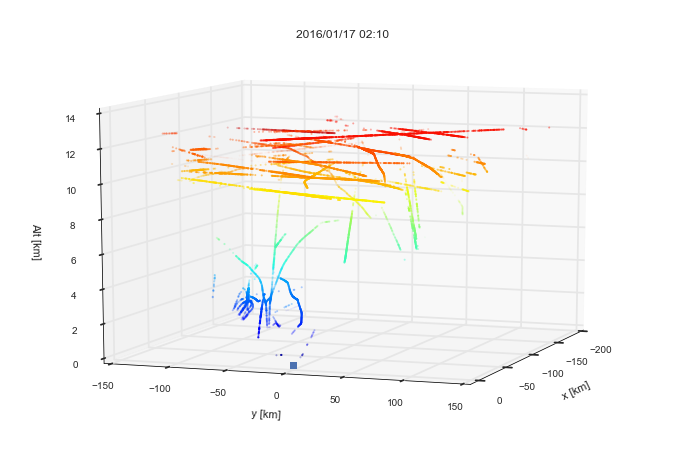

In [155]:
def make_3dplot(time=2, delta=6, el=10, az=20):
    '''
    time in days
    delta in hours
    
    '''
    d = delta/24.0
    
    fig = pylab.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel('x [km]')
    ax.set_ylabel('y [km]')
    ax.set_zlabel('Alt [km]')

    ax.plot([0],[0],zs=[0],marker='s')
    ii = np.where( (clean['datenum'] > time-d) &
                   (clean['datenum'] <= time) )[0]
    z = clean['alt'][ii]*0.0003048
    #rise and fall
#     alpha = np.abs(clean['datenum'][ii] - time) / d
    # fall only
    alpha = np.abs(clean['datenum'][ii] - (time)) / d
    
    c = pylab.cm.jet(z/14.0)
#     c = pylab.cm.jet(alpha)
    c[:,-1] = np.clip(1.0-alpha,0.02,0.7)
    ax.scatter(clean['x'][ii], clean['y'][ii], z, 
#                c=z, cmap=pylab.cm.jet, vmin=0, vmax=12, 
               c=c,
               marker='o', s=4, linewidths=0, #marker='.',
               edgecolor='none')
    
    ax.view_init(elev=el, azim=az)
    ax.autoscale(False)
    ax.set_zlim(0,14)
    ax.set_xlim(-200,10)
    ax.set_ylim(-150,150)
    
#     i = ii[np.argmin(clean['datenum'][ii])]
    i = np.max(ii)
    note = ' [Snow]' if (clean['datenum'][i] > 8) and (clean['datenum'][i] < 10) else ''
    pylab.title('{} {}{}'.format(clean['date'][i], clean['time'][i][:5], note),
               fontsize=12)
    
    return ax



# _ = interact(make_3dplot, time=(0,14,1), delta=(0,24,1), el=(0,90,10), az=(20,120,10))
ax = make_3dplot()

In [10]:
def _movie():
    nframes = 1200
    elevs = np.concatenate([np.linspace(5,25,nframes/2),
                            np.linspace(25,5,nframes/2)])
    azims = np.linspace(20,360+20,nframes)
    times = np.linspace(0,14,nframes)
    delta = 6.0

    for i,(e,a,t) in enumerate(zip(elevs, azims, times)):
        outfile = '/Users/ajmendez/tmp/flight/movies/pan_{:04d}.png'.format(i)
        basedir = os.path.dirname(outfile)
        if not os.path.exists(basedir):
            os.makedirs(basedir)
        if os.path.exists(outfile):
            continue

#         print i,
        print '.',
        ax = make_3dplot(time=t, delta=delta, el=e, az=a)
        
#         if i == 0:
#             ax = make_3dplot(e,a)
#         ax.view_init(elev=e, azim=a)
        pylab.savefig(outfile)
        pylab.close()
_movie()

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [27]:
import geoplotlib
from geoplotlib.utils import read_csv, BoundingBox
from IPython.display import Image

In [166]:
class NoDot(geoplotlib.layers.DotDensityLayer):
    def invalidate(self, proj):
        # geodesic coords
        x,y = proj.lonlat_to_screen(self.data['lon'], self.data['lat'])
        self.x = x - proj.xtile*geoplotlib.core.TILE_SIZE
        self.y = y + proj.ytile*geoplotlib.core.TILE_SIZE
        
        hx,hy = proj.lonlat_to_screen([-76.623450], [39.331832])
        print hx - proj.xtile*geoplotlib.core.TILE_SIZE
        print hy + proj.ytile*geoplotlib.core.TILE_SIZE
        
        self.painter = geoplotlib.layers.BatchPainter()
#         self.painter.points(x,y)
#         super(NoDot, self).invalidate(proj)

[ 289.71111111]
[ 123.62788632]


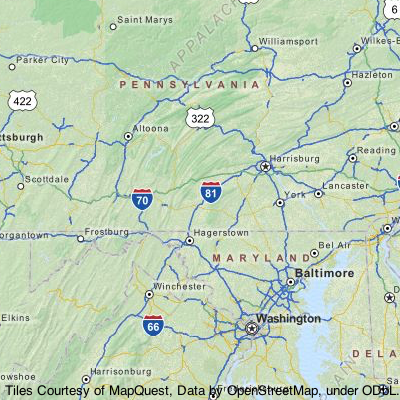

In [167]:
pname = '/Users/ajmendez/tmp/flight_movie.png'
# geoplotlib.tiles_provider('darkmatter')

# tmpdot = geoplotlib.dot(clean)
tmp = NoDot(clean)
geoplotlib.add_layer(tmp)

# bbox = BoundingBox(40.9,-77.8,38.7,-78.1)
# bbox = geoplotlib.utils.BoundingBox.from_points(clean['lon'], clean['lat'])
bbox = geoplotlib.utils.BoundingBox(40.5,-78.0,38.5,-76)
geoplotlib.set_bbox(bbox)

geoplotlib.set_window_size(400, 400)


# geoplotlib.show()
geoplotlib.savefig(pname.replace('.png',''))
Image(pname)
# geoplotlib.inline(400)

In [160]:
img = pylab.imread(pname)

In [ ]:
np.fl

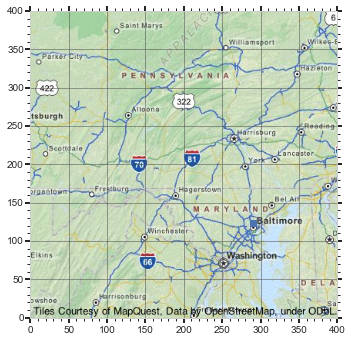

In [173]:
setup(xr=[0,400], yr=[0,400], aspect='equal')
pylab.imshow(np.flipud(img), origin='lower', )
# pylab.plot(tmp.x, tmp.y, '.')
pylab.plot([289.71111111],[123.62788632],marker='s')

In [162]:
clean['px'] = tmp.x
clean['py'] = tmp.y

In [199]:
clean.to_csv('/Users/ajmendez/tmp/flight/flight_clean_2.csv')

In [185]:
start_date = date2num(parser.parse('{} {}'.format(clean['date'][0], clean['time'][0])))
start_date

735978.1002500464

In [190]:
'{:%Y/%m/%d %H:%M}'.format(num2date(start_date))

'2016/01/15 02:24'

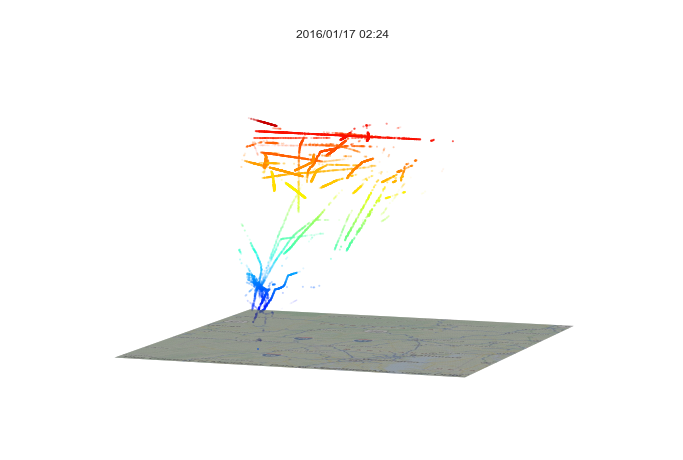

In [197]:
def setup_ax(el=10, az=20):
        # Setup plot, and show the home
    fig = pylab.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot([289.71111111], [123.62788632], [0], marker='s', markersize=2)
    
    ax.view_init(elev=el, azim=az)
    ax.autoscale(False)
    ax.set_zlim(0,14)
    ax.set_xlim(0,400)
    ax.set_ylim(0,400)
    
    for a in (ax.w_xaxis, ax.w_yaxis, ax.w_zaxis):
        for t in a.get_ticklines()+a.get_ticklabels():
            t.set_visible(False)
        a.line.set_visible(False)
        a.pane.set_visible(False)
        
    ax.grid('off')
    
    x, y = np.ogrid[0:img.shape[0], 0:img.shape[1]]
    stride = 1
    ax.surface = ax.plot_surface(x, y, 0, rstride=stride, cstride=stride, facecolors=img, lw=0)
    
    return ax


def add_points(ax, t=2, delta=6):
    '''
    t is the time in days since the start
    delta in hours
    '''
    d = delta/24.0
    ii = np.where( (clean['datenum'] > t-d) &
                   (clean['datenum'] <= t) )[0]
    z = clean['alt'][ii]*0.0003048
    
    # Determine Colors
    c = pylab.cm.jet(z/14.0)
    alpha = np.abs(clean['datenum'][ii] - t) / d
    c[:,-1] = np.clip(1.0-alpha,0.02,0.7)
    
    ax.scatter(clean['px'][ii], clean['py'][ii], z, 
               c=c, marker='o', s=4, linewidths=0, edgecolor='none')

    date = start_date + t
    note = ' [Snow]' if (t > 8) and (t < 10) else ''
    pylab.title('{:%Y/%m/%d %H:%M} {}'.format(num2date(date), note), fontsize=12)


# _ = interact(make_3dplot, time=(0,14,1), delta=(0,24,1), el=(0,90,10), az=(20,120,10))
ax = setup_ax()
add_points(ax)

In [ ]:
def _movie():
    nframes = 600
    elevs = np.concatenate([np.linspace(25,45,nframes/2),
                            np.linspace(45,25,nframes/2)])
    azims = np.linspace(20,360+20,nframes)
    times = np.linspace(0,14,nframes)
    delta = 6.0

    for i,(e,a,t) in enumerate(zip(elevs, azims, times)):
        outfile = '/Users/ajmendez/tmp/flight/movies/pan_{:04d}.png'.format(i)
        basedir = os.path.dirname(outfile)
        if not os.path.exists(basedir):
            os.makedirs(basedir)
        if os.path.exists(outfile):
            continue
        
        ax = setup_ax(el=e,az=a)
        add_points(ax, t=t, delta=delta)
        
        pylab.savefig(outfile)
        pylab.close()
        
        print '.',
_movie()